In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [3]:
from mstcn_model import *
from utility.adaptive_data_loader import Breakfast, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='2'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=8,
    learning_rate=5e-4,
    weight_decay=0,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=1,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=1,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split1/",
    project_name="breakfast-split-1",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 8, 'learning_rate': 0.0005, 'weight_decay': 0, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 1, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 1, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split1/', 'project_name': 'breakfast-split-1', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split1.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split1.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_split':

In [7]:
traindataset = Breakfast(config, fold='train', fold_file_name=config.train_split_file)
testdataset = Breakfast(config, fold='test', fold_file_name=config.test_split_file)

Number of videos logged in train fold is 1460
Number of videos not found in train fold is 0
Number of videos logged in test fold is 252
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, 
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4,
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)

In [9]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [10]:
loaded_vidid_selected_frames = np.load("/home/dipika16/ar/TimestampActionSeg/data/breakfast_annotation_all.npy", allow_pickle=True).item()
# loaded_vidid_selected_frames
video_id_boundary_frames = pickle.load(open("dump_dir/chunk_1_video_id_boundary_frames_dict.pkl", "rb"))
# video_id_boundary_frames

In [11]:
loaded_mean_var_actions = pickle.load(open("dump_dir/mean_var_actions.pkl", "rb"))
def get_possion_prob(cur_len, cur_class):
    mean_class, std_class = loaded_mean_var_actions[cur_class]
    mean_class = mean_class * 10
    prob = cur_len * torch.log(torch.tensor(mean_class, device=device) + 1e-5)
    prob = prob - mean_class
    factorials = torch.cumsum(torch.log(torch.arange(1, torch.max(cur_len)+1, 1).type(torch.float).to(device)), 
                              dim=0)[min(cur_len)-1:]
    prob = prob - factorials
    return prob

# get_possion_prob(torch.arange(10, 21), 20)

In [12]:
prob_video_each_segment_dict = {}

In [13]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels):
    prob_each_segment = []
    
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
    cur_boundary = 0
    for i, cur_ele in enumerate(selected_frames[:-1]):

        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[cur_ele]
        label_next_ele = labels[next_ele]

        indices = torch.arange(cur_ele, next_ele).to(cumsum_feat.device)
        strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
        end_index = cumsum_feat[next_ele - 1, :][None, :]
        left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
        right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]

        cur_boundary_len = indices - cur_boundary
        len_prob = get_possion_prob(cur_boundary_len, label_cur_ele.item())

        prob = torch.softmax((left_sum + right_sum + len_prob), dim=0)
#         prob = torch.softmax((left_sum + right_sum), dim=0)

        cur_boundary = round(np.sum(np.arange(cur_ele, next_ele, 1) * prob.detach().cpu().numpy()).item())
        prob_each_segment.append(prob)
    
    return prob_each_segment

In [14]:
def calculate_element_probb(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
        prob_video = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [15]:
def get_estimated_loss(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames[0]
        if start_ele_idx > 0:
            start_ele_label_idx = labels[selected_frames[0]]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob.unsqueeze(0))
        
        for i, cur_ele in enumerate(selected_frames[:-1]):
            next_ele = selected_frames[i + 1]
            label_cur_ele = labels[cur_ele]
            label_next_ele = labels[next_ele]

            indices = torch.arange(cur_ele, next_ele)
            strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
            end_index = cumsum_feat[next_ele - 1, :][None, :]
            left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
            right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]
            current_vid_prob_arr.append((left_sum + right_sum)  * (prob_each_video[i]))
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = labels[selected_frames[-1]]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames[-1] - 1, :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob.unsqueeze(0))
            
        loss_arr.append(torch.cat(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr

In [16]:
train_split_file_list = set(open(config.train_split_file).read().split("\n")[0:-1])

def get_estimated_boundaries():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames, video_id_boundary_frames
    estimated_boundary_dict = {}
    for ele in video_id_boundary_frames.keys():
        if (ele + ".txt") not in train_split_file_list:
            continue
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        selected_ele_list = loaded_vidid_selected_frames[ele + ".txt"]
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_ele_list[i], selected_ele_list[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = round(estimated_boundary.item())
            
            if (estimated_boundary < selected_ele_list[i]) or (estimated_boundary > selected_ele_list[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [17]:
train_split_file_list = set(open(config.train_split_file).read().split("\n")[0:-1])

def get_boundary_err():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for ele in video_id_boundary_frames.keys():
        if ele + ".txt" not in train_split_file_list:
            continue
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(video_id_boundary_frames[ele][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = video_id_boundary_frames[ele][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Train Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"Train From boundary avergage accuracy = {correct * 100.0 / total:.3f}")

In [18]:
set_seed()
model = MultiStageModel(num_stages=4, num_layers=10, num_f_maps=64, dim=2048, num_classes=48).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Requires loaded_vidid_selected_frames, boundaries_dict
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [19]:
def get_single_random(labels_all, video_ids):
    # Generate target for only timestamps. Do not generate pseudo labels at first 30 epochs.
    boundary_target_tensor = torch.ones((labels_all.shape[0], labels_all.shape[1]), dtype=torch.long, device=labels_all.device) * (-100)
    for iter_num, labels in enumerate(labels_all):
        cur_vidid = video_ids[iter_num]
        frame_idx_tensor = torch.from_numpy(np.array(loaded_vidid_selected_frames[cur_vidid + ".txt"]))
        boundary_target_tensor[iter_num, frame_idx_tensor] = labels[frame_idx_tensor]

    return boundary_target_tensor

In [22]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split1/'

In [27]:
initialize_epoch = 15
expectation_cal_gap = 5
best_val_acc = 0
for epoch in range(15, 1000):
    print("Starting Training")
    model.train()
    for i, item in enumerate(trainloader):
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
        optimizer.zero_grad()
        
        middle_pred, predictions = model(item_0, src_mask_mse)
        boundary_target_tensor = get_single_random(item_2, item[4])
        
        loss = 0
        for p in predictions:
            if epoch <= initialize_epoch:
                loss += ce_criterion(p, boundary_target_tensor)
                loss += 0.15 * torch.mean(torch.clamp(mse_criterion(F.log_softmax(p[:, :, 1:], dim=1), 
                                                                    F.log_softmax(p.detach()[:, :, :-1], dim=1)), min=0,
                                            max=16) * src_mask_mse[:, :, 1:])
            else:
                prob = torch.softmax(p, dim=1)
                prob = prob.permute(0, 2, 1)
                es_loss, _ = get_estimated_loss(prob, item_1, item[4], item_2)
                loss += es_loss
            

        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                pred = torch.argmax(predictions[-1], dim=1)
                correct = float(torch.sum((pred == item_2) * src_mask).item())
                total = float(torch.sum(src_mask).item())
                print(f"Training:: Epoch {epoch}, Iteration {i}, Current loss {loss.item()}" +
                      f" Accuracy {correct * 100.0 / total}")
    if epoch == initialize_epoch:
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-initial-15-epochs.wt")
    # Calculating Expectation Step
    model.eval()
    if (epoch >= initialize_epoch) and (epoch % expectation_cal_gap == 0):
        print("Calculating Expectation")
        correct = 0.0
        total = 0.0

        for i, item in enumerate(trainloader):
            with torch.no_grad():
                item_0 = item[0].to(device)
                item_1 = item[1].to(device)
                item_2 = item[2].to(device)
                src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
                src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

                middle_pred, predictions = model(item_0, src_mask_mse)
                prob = torch.softmax(predictions[-1], dim=1)
                prob = prob.permute(0, 2, 1)
                calculate_element_probb(prob, item_1, item[4], item_2)
                
                if i % 10 == 0:
#                     pred = torch.argmax(prob, dim=2)
#                     correct += float(torch.sum((pred == item_2) * src_mask).item())
#                     total += float(torch.sum(src_mask).item())
                    print(f"Epoch {epoch} iter {i}")
                    
#         print(f"Epoch {epoch} After Expectation}, train acc. {correct * 100.0 / total: .3f}")
        get_boundary_err()

    print("Calculating Validation Data Accuracy")
    correct = 0.0
    total = 0.0
    for i, item in enumerate(testloader):
        with torch.no_grad():
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

            middle_pred, predictions = model(item_0, src_mask_mse)

            pred = torch.argmax(predictions[-1], dim=1)
            correct += float(torch.sum((pred == item_2) * src_mask).item())
            total += float(torch.sum(src_mask).item())
    val_acc = correct * 100.0 / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-best-model.wt")
    torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-last-model.wt")
    print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

Starting Training
Training:: Epoch 15, Iteration 0, Current loss 1.4878519773483276 Accuracy 81.80546589197331
Training:: Epoch 15, Iteration 10, Current loss 1.5497926473617554 Accuracy 69.16089400078421
Training:: Epoch 15, Iteration 20, Current loss 1.2525343894958496 Accuracy 77.62193845509734
Training:: Epoch 15, Iteration 30, Current loss 1.6481863260269165 Accuracy 66.33730834752981
Training:: Epoch 15, Iteration 40, Current loss 1.8469901084899902 Accuracy 80.26038437693738
Training:: Epoch 15, Iteration 50, Current loss 1.8984049558639526 Accuracy 76.39811880175851
Training:: Epoch 15, Iteration 60, Current loss 1.526989221572876 Accuracy 77.93367346938776
Training:: Epoch 15, Iteration 70, Current loss 1.6769968271255493 Accuracy 66.9547926304683
Training:: Epoch 15, Iteration 80, Current loss 1.2930707931518555 Accuracy 63.7310146658208
Training:: Epoch 15, Iteration 90, Current loss 1.3917895555496216 Accuracy 73.70881649180932
Training:: Epoch 15, Iteration 100, Current lo

Training:: Epoch 19, Iteration 70, Current loss 3.0524833589722236 Accuracy 74.71530787060365
Training:: Epoch 19, Iteration 80, Current loss 2.0651702590364884 Accuracy 85.42883211678833
Training:: Epoch 19, Iteration 90, Current loss 1.7124813506378262 Accuracy 87.35917201229044
Training:: Epoch 19, Iteration 100, Current loss 3.3362358321085064 Accuracy 76.81374425727412
Training:: Epoch 19, Iteration 110, Current loss 1.7950045622553805 Accuracy 81.42073535002444
Training:: Epoch 19, Iteration 120, Current loss 2.126823425286961 Accuracy 83.85610879578854
Training:: Epoch 19, Iteration 130, Current loss 2.9768558594280914 Accuracy 73.15580286168522
Training:: Epoch 19, Iteration 140, Current loss 2.817849183660167 Accuracy 79.15938410320433
Training:: Epoch 19, Iteration 150, Current loss 4.321754579686055 Accuracy 68.10666968633224
Training:: Epoch 19, Iteration 160, Current loss 2.4505387251346438 Accuracy 74.4894366197183
Training:: Epoch 19, Iteration 170, Current loss 1.817753

Training:: Epoch 23, Iteration 90, Current loss 0.9813635593828701 Accuracy 85.28294598596537
Training:: Epoch 23, Iteration 100, Current loss 1.3784209664106215 Accuracy 85.81620128873888
Training:: Epoch 23, Iteration 110, Current loss 0.8432603545047005 Accuracy 88.58033858033858
Training:: Epoch 23, Iteration 120, Current loss 1.1098801494359118 Accuracy 81.44754599048228
Training:: Epoch 23, Iteration 130, Current loss 1.22628467445049 Accuracy 86.55637012086387
Training:: Epoch 23, Iteration 140, Current loss 1.3827306751383857 Accuracy 79.01209123385546
Training:: Epoch 23, Iteration 150, Current loss 1.5066568255454902 Accuracy 86.07273231366388
Training:: Epoch 23, Iteration 160, Current loss 0.9847208572662747 Accuracy 84.22584040116386
Training:: Epoch 23, Iteration 170, Current loss 1.3256787428221037 Accuracy 79.63215258855585
Training:: Epoch 23, Iteration 180, Current loss 0.7728877073305895 Accuracy 91.27404718693285
Calculating Validation Data Accuracy
Validation:: Epo

Training:: Epoch 27, Iteration 110, Current loss 1.54628488227036 Accuracy 88.15872020075282
Training:: Epoch 27, Iteration 120, Current loss 1.9131388090097228 Accuracy 80.04300634855622
Training:: Epoch 27, Iteration 130, Current loss 0.8063170503230674 Accuracy 90.29196269982238
Training:: Epoch 27, Iteration 140, Current loss 1.636999387428095 Accuracy 84.534127843987
Training:: Epoch 27, Iteration 150, Current loss 0.8357684648851651 Accuracy 82.26182316655243
Training:: Epoch 27, Iteration 160, Current loss 2.4304928888586663 Accuracy 80.09852216748769
Training:: Epoch 27, Iteration 170, Current loss 1.410142293435329 Accuracy 79.54310980103169
Training:: Epoch 27, Iteration 180, Current loss 1.6574402690598231 Accuracy 88.4428960920933
Calculating Validation Data Accuracy
Validation:: Epoch 27, Probability Accuracy 66.10752994527346
Starting Training
Training:: Epoch 28, Iteration 0, Current loss 1.5421890881160867 Accuracy 82.9865556978233
Training:: Epoch 28, Iteration 10, Cur

Training:: Epoch 31, Iteration 130, Current loss 0.653428008154144 Accuracy 88.40050432589888
Training:: Epoch 31, Iteration 140, Current loss 0.7939558728330544 Accuracy 88.6160159164387
Training:: Epoch 31, Iteration 150, Current loss 0.7824096340927554 Accuracy 89.68853432911823
Training:: Epoch 31, Iteration 160, Current loss 1.3958498270019144 Accuracy 80.05887300252313
Training:: Epoch 31, Iteration 170, Current loss 1.503193521057518 Accuracy 84.25298483381737
Training:: Epoch 31, Iteration 180, Current loss 1.2887007245285662 Accuracy 88.85792407193185
Calculating Validation Data Accuracy
Validation:: Epoch 31, Probability Accuracy 65.29949230543981
Starting Training
Training:: Epoch 32, Iteration 0, Current loss 1.382227008173126 Accuracy 73.31301432490095
Training:: Epoch 32, Iteration 10, Current loss 1.0217974162036216 Accuracy 87.56088422630198
Training:: Epoch 32, Iteration 20, Current loss 1.299990798872436 Accuracy 85.96603839645212
Training:: Epoch 32, Iteration 30, Cu

Calculating Expectation
Epoch 35 iter 0
Epoch 35 iter 10
Epoch 35 iter 20
Epoch 35 iter 30
Epoch 35 iter 40
Epoch 35 iter 50
Epoch 35 iter 60
Epoch 35 iter 70
Epoch 35 iter 80
Epoch 35 iter 90
Epoch 35 iter 100
Epoch 35 iter 110
Epoch 35 iter 120
Epoch 35 iter 130
Epoch 35 iter 140
Epoch 35 iter 150
Epoch 35 iter 160
Epoch 35 iter 170
Epoch 35 iter 180
Train Boundary avergage error = 87.284
Train From boundary avergage accuracy = 88.449
Calculating Validation Data Accuracy
Validation:: Epoch 35, Probability Accuracy 69.84974931839136
Starting Training
Training:: Epoch 36, Iteration 0, Current loss 0.5470055158866793 Accuracy 86.49942068409652
Training:: Epoch 36, Iteration 10, Current loss 0.6344957356994132 Accuracy 87.79803646563815
Training:: Epoch 36, Iteration 20, Current loss 0.4718931960310333 Accuracy 89.33670555600881
Training:: Epoch 36, Iteration 30, Current loss 0.457473133968501 Accuracy 83.85975994946304
Training:: Epoch 36, Iteration 40, Current loss 0.7829243487046926 A

Training:: Epoch 40, Iteration 0, Current loss 0.38844721809096927 Accuracy 84.01760848081933
Training:: Epoch 40, Iteration 10, Current loss 0.4950499023689709 Accuracy 91.08992954828015
Training:: Epoch 40, Iteration 20, Current loss 0.42555270409146273 Accuracy 86.22320854990363
Training:: Epoch 40, Iteration 30, Current loss 0.6069050117704903 Accuracy 87.40069084628671
Training:: Epoch 40, Iteration 40, Current loss 0.6432520444946698 Accuracy 89.03623747108712
Training:: Epoch 40, Iteration 50, Current loss 0.32604875033670977 Accuracy 91.4488854727133
Training:: Epoch 40, Iteration 60, Current loss 0.4267201335131895 Accuracy 85.42557326078507
Training:: Epoch 40, Iteration 70, Current loss 0.3554524532316852 Accuracy 88.54574363992172
Training:: Epoch 40, Iteration 80, Current loss 0.30897209077507815 Accuracy 92.61711933419839
Training:: Epoch 40, Iteration 90, Current loss 0.44144711080918153 Accuracy 90.66567497210859
Training:: Epoch 40, Iteration 100, Current loss 0.389700

Training:: Epoch 44, Iteration 20, Current loss 0.8142177910288522 Accuracy 90.90564607805987
Training:: Epoch 44, Iteration 30, Current loss 0.6510584565994422 Accuracy 90.18166972851603
Training:: Epoch 44, Iteration 40, Current loss 0.6945600274915411 Accuracy 86.49534737958632
Training:: Epoch 44, Iteration 50, Current loss 0.6522237832314436 Accuracy 88.87076819255427
Training:: Epoch 44, Iteration 60, Current loss 1.0075530413404026 Accuracy 86.79122875308161
Training:: Epoch 44, Iteration 70, Current loss 1.271683025775059 Accuracy 83.23634735899732
Training:: Epoch 44, Iteration 80, Current loss 1.2138941704840716 Accuracy 82.54241580146872
Training:: Epoch 44, Iteration 90, Current loss 1.0049763862164849 Accuracy 84.83888844905391
Training:: Epoch 44, Iteration 100, Current loss 1.442895216973335 Accuracy 85.12142787476836
Training:: Epoch 44, Iteration 110, Current loss 1.139321742948964 Accuracy 87.79332537874679
Training:: Epoch 44, Iteration 120, Current loss 1.2857023882

Training:: Epoch 48, Iteration 40, Current loss 0.32904605945102955 Accuracy 88.42373842373843
Training:: Epoch 48, Iteration 50, Current loss 0.3822170307084815 Accuracy 92.21944675733185
Training:: Epoch 48, Iteration 60, Current loss 0.3680558093958309 Accuracy 82.41497710922171
Training:: Epoch 48, Iteration 70, Current loss 0.3281565450393163 Accuracy 86.793953858393
Training:: Epoch 48, Iteration 80, Current loss 0.47067040750216516 Accuracy 84.65929109999296
Training:: Epoch 48, Iteration 90, Current loss 0.32274214335183593 Accuracy 88.62452772388441
Training:: Epoch 48, Iteration 100, Current loss 0.2922967807875599 Accuracy 89.17901168780419
Training:: Epoch 48, Iteration 110, Current loss 0.45147454699939227 Accuracy 77.97273197952022
Training:: Epoch 48, Iteration 120, Current loss 0.3336560228709048 Accuracy 87.66271240782302
Training:: Epoch 48, Iteration 130, Current loss 0.2715206465016316 Accuracy 88.1697687535251
Training:: Epoch 48, Iteration 140, Current loss 0.2925

Training:: Epoch 52, Iteration 60, Current loss 0.36388140788087675 Accuracy 84.41659632491397
Training:: Epoch 52, Iteration 70, Current loss 0.2960834931100997 Accuracy 90.50650429006366
Training:: Epoch 52, Iteration 80, Current loss 0.3109966599349396 Accuracy 86.59976686432518
Training:: Epoch 52, Iteration 90, Current loss 0.28919786023467026 Accuracy 88.55704369928634
Training:: Epoch 52, Iteration 100, Current loss 0.3419214064116305 Accuracy 84.22462450971013
Training:: Epoch 52, Iteration 110, Current loss 0.19450090442795698 Accuracy 93.24372125928546
Training:: Epoch 52, Iteration 120, Current loss 0.3030670808129949 Accuracy 82.89667055186743
Training:: Epoch 52, Iteration 130, Current loss 0.3690111290176363 Accuracy 87.22991689750693
Training:: Epoch 52, Iteration 140, Current loss 0.3299887959490006 Accuracy 90.94807050976655
Training:: Epoch 52, Iteration 150, Current loss 0.39458325745925443 Accuracy 91.34710503345941
Training:: Epoch 52, Iteration 160, Current loss 0

Training:: Epoch 56, Iteration 80, Current loss 0.260750047631798 Accuracy 89.8688781799843
Training:: Epoch 56, Iteration 90, Current loss 0.4149727628352917 Accuracy 86.4698031364698
Training:: Epoch 56, Iteration 100, Current loss 0.3456870660479092 Accuracy 89.12954359114512
Training:: Epoch 56, Iteration 110, Current loss 0.36604835553487713 Accuracy 89.54392139609914
Training:: Epoch 56, Iteration 120, Current loss 0.3292075363072061 Accuracy 90.20017002859572
Training:: Epoch 56, Iteration 130, Current loss 0.5691411575715967 Accuracy 89.21206961785849
Training:: Epoch 56, Iteration 140, Current loss 0.35445836976880196 Accuracy 88.68499503146737
Training:: Epoch 56, Iteration 150, Current loss 1.1664347129865222 Accuracy 84.61039344068897
Training:: Epoch 56, Iteration 160, Current loss 0.9846860254152014 Accuracy 83.4349963583394
Training:: Epoch 56, Iteration 170, Current loss 1.2025309027813211 Accuracy 84.10402830364347
Training:: Epoch 56, Iteration 180, Current loss 0.555

Training:: Epoch 60, Iteration 150, Current loss 0.48706702805187635 Accuracy 83.02875829566221
Training:: Epoch 60, Iteration 160, Current loss 1.3029426116112797 Accuracy 83.54380077711056
Training:: Epoch 60, Iteration 170, Current loss 0.6355849027435674 Accuracy 89.0217953878889
Training:: Epoch 60, Iteration 180, Current loss 0.5018386831775036 Accuracy 91.2230114635347
Calculating Expectation
Epoch 60 iter 0
Epoch 60 iter 10
Epoch 60 iter 20
Epoch 60 iter 30
Epoch 60 iter 40
Epoch 60 iter 50
Epoch 60 iter 60
Epoch 60 iter 70
Epoch 60 iter 80
Epoch 60 iter 90
Epoch 60 iter 100
Epoch 60 iter 110
Epoch 60 iter 120
Epoch 60 iter 130
Epoch 60 iter 140
Epoch 60 iter 150
Epoch 60 iter 160
Epoch 60 iter 170
Epoch 60 iter 180
Train Boundary avergage error = 88.940
Train From boundary avergage accuracy = 88.319
Calculating Validation Data Accuracy
Validation:: Epoch 60, Probability Accuracy 68.60247476366284
Starting Training
Training:: Epoch 61, Iteration 0, Current loss 0.95222922043998

Training:: Epoch 64, Iteration 170, Current loss 0.23397482774416734 Accuracy 91.10603148215492
Training:: Epoch 64, Iteration 180, Current loss 0.3721333214400143 Accuracy 89.24207543828581
Calculating Validation Data Accuracy
Validation:: Epoch 64, Probability Accuracy 68.41945938245664
Starting Training
Training:: Epoch 65, Iteration 0, Current loss 0.455156181661027 Accuracy 90.21730045967405
Training:: Epoch 65, Iteration 10, Current loss 0.2994140663188707 Accuracy 93.90678397440558
Training:: Epoch 65, Iteration 20, Current loss 0.29591789867751955 Accuracy 87.15861118290687
Training:: Epoch 65, Iteration 30, Current loss 0.43267273305107845 Accuracy 90.91863941181224
Training:: Epoch 65, Iteration 40, Current loss 0.3707517699578055 Accuracy 91.2474645030426
Training:: Epoch 65, Iteration 50, Current loss 0.28377862968563555 Accuracy 89.68958550174493
Training:: Epoch 65, Iteration 60, Current loss 0.22364916674271598 Accuracy 92.71604938271605
Training:: Epoch 65, Iteration 70

Training:: Epoch 68, Iteration 180, Current loss 0.25761419661479096 Accuracy 89.45401513079938
Calculating Validation Data Accuracy
Validation:: Epoch 68, Probability Accuracy 68.71703249957461
Starting Training
Training:: Epoch 69, Iteration 0, Current loss 0.2800892428015493 Accuracy 91.4149940599012
Training:: Epoch 69, Iteration 10, Current loss 0.3408190945907643 Accuracy 85.34190693493743
Training:: Epoch 69, Iteration 20, Current loss 0.3200412579849464 Accuracy 84.96539537623325
Training:: Epoch 69, Iteration 30, Current loss 0.2643728373399598 Accuracy 81.46634242251773
Training:: Epoch 69, Iteration 40, Current loss 0.232119777105271 Accuracy 90.24031387935263
Training:: Epoch 69, Iteration 50, Current loss 0.2821073868030873 Accuracy 85.83308285742912
Training:: Epoch 69, Iteration 60, Current loss 0.2535971134994726 Accuracy 88.74555160142349
Training:: Epoch 69, Iteration 70, Current loss 0.21596326472332789 Accuracy 83.08946189409465
Training:: Epoch 69, Iteration 80, Cu

Validation:: Epoch 72, Probability Accuracy 68.44359762732924
Starting Training
Training:: Epoch 73, Iteration 0, Current loss 0.33375032646125274 Accuracy 87.46468926553672
Training:: Epoch 73, Iteration 10, Current loss 0.23858975932689472 Accuracy 90.64949006977993
Training:: Epoch 73, Iteration 20, Current loss 0.2552930787621751 Accuracy 86.59876279863481
Training:: Epoch 73, Iteration 30, Current loss 0.2339653236384213 Accuracy 86.5845311430527
Training:: Epoch 73, Iteration 40, Current loss 0.26291144336439143 Accuracy 90.83477720023102
Training:: Epoch 73, Iteration 50, Current loss 0.2497612893028463 Accuracy 90.97879008338464
Training:: Epoch 73, Iteration 60, Current loss 0.3341715536745971 Accuracy 84.18585269298886
Training:: Epoch 73, Iteration 70, Current loss 0.4953446388499788 Accuracy 84.72331350319901
Training:: Epoch 73, Iteration 80, Current loss 0.29405907597279957 Accuracy 86.60991979047307
Training:: Epoch 73, Iteration 90, Current loss 0.251649731800533 Accura

Training:: Epoch 77, Iteration 10, Current loss 0.2848568279125818 Accuracy 92.00833912439194
Training:: Epoch 77, Iteration 20, Current loss 0.2440099448841129 Accuracy 91.60742153632738
Training:: Epoch 77, Iteration 30, Current loss 0.30442674489165433 Accuracy 89.00119134545174
Training:: Epoch 77, Iteration 40, Current loss 0.28991109495104966 Accuracy 89.49291914116034
Training:: Epoch 77, Iteration 50, Current loss 0.502266382981954 Accuracy 88.27668326477593
Training:: Epoch 77, Iteration 60, Current loss 0.2742633201476747 Accuracy 80.7991192850667
Training:: Epoch 77, Iteration 70, Current loss 0.27715837565427337 Accuracy 89.06542932133483
Training:: Epoch 77, Iteration 80, Current loss 0.32537599620986324 Accuracy 85.21859314759584
Training:: Epoch 77, Iteration 90, Current loss 0.2849555644020786 Accuracy 87.44769874476988
Training:: Epoch 77, Iteration 100, Current loss 0.22472298304816646 Accuracy 85.43556131392424
Training:: Epoch 77, Iteration 110, Current loss 0.24507

Training:: Epoch 81, Iteration 30, Current loss 0.33532072518053335 Accuracy 90.52961127054526
Training:: Epoch 81, Iteration 40, Current loss 0.6324839188682932 Accuracy 79.16666666666667
Training:: Epoch 81, Iteration 50, Current loss 0.356962048645716 Accuracy 88.82629107981221
Training:: Epoch 81, Iteration 60, Current loss 0.5529402252015286 Accuracy 81.1490359562272
Training:: Epoch 81, Iteration 70, Current loss 0.39677307172863946 Accuracy 82.10037844656695
Training:: Epoch 81, Iteration 80, Current loss 0.330915121016031 Accuracy 87.76383342840845
Training:: Epoch 81, Iteration 90, Current loss 0.4843992242081982 Accuracy 88.51067553377669
Training:: Epoch 81, Iteration 100, Current loss 0.32337514423822844 Accuracy 92.52846424261504
Training:: Epoch 81, Iteration 110, Current loss 0.4222734671016845 Accuracy 86.01883986117997
Training:: Epoch 81, Iteration 120, Current loss 0.47003269079644683 Accuracy 88.73781426372499
Training:: Epoch 81, Iteration 130, Current loss 0.32290

Training:: Epoch 85, Iteration 90, Current loss 0.2207269226369007 Accuracy 89.39687606886329
Training:: Epoch 85, Iteration 100, Current loss 0.322969971453406 Accuracy 86.94623373208887
Training:: Epoch 85, Iteration 110, Current loss 0.20773536286535166 Accuracy 90.28901734104046
Training:: Epoch 85, Iteration 120, Current loss 0.337326681896871 Accuracy 82.08900331004045
Training:: Epoch 85, Iteration 130, Current loss 0.35966883239319286 Accuracy 85.83136637817991
Training:: Epoch 85, Iteration 140, Current loss 0.26404741819120037 Accuracy 88.3271375464684
Training:: Epoch 85, Iteration 150, Current loss 0.2638936671319938 Accuracy 91.66525207944322
Training:: Epoch 85, Iteration 160, Current loss 0.21824962204370246 Accuracy 88.05271585170587
Training:: Epoch 85, Iteration 170, Current loss 0.27368075830247557 Accuracy 87.72404830237721
Training:: Epoch 85, Iteration 180, Current loss 0.19582458665252428 Accuracy 87.98445541434724
Calculating Expectation
Epoch 85 iter 0
Epoch 85

Training:: Epoch 89, Iteration 100, Current loss 0.26246849053994536 Accuracy 83.30153742565369
Training:: Epoch 89, Iteration 110, Current loss 0.2803248356674421 Accuracy 89.18825561312607
Training:: Epoch 89, Iteration 120, Current loss 0.2141897570260779 Accuracy 93.42998955067921
Training:: Epoch 89, Iteration 130, Current loss 0.1698717150853087 Accuracy 91.09600490332646
Training:: Epoch 89, Iteration 140, Current loss 0.266090544223852 Accuracy 80.10195009187363
Training:: Epoch 89, Iteration 150, Current loss 0.16258954909130052 Accuracy 88.98895990703079
Training:: Epoch 89, Iteration 160, Current loss 0.23869105514174302 Accuracy 90.52222338972365
Training:: Epoch 89, Iteration 170, Current loss 0.15558147336357225 Accuracy 90.77932807049753
Training:: Epoch 89, Iteration 180, Current loss 0.21520816084140387 Accuracy 87.93008532892927
Calculating Validation Data Accuracy
Validation:: Epoch 89, Probability Accuracy 67.7499198689412
Starting Training
Training:: Epoch 90, Iter

Training:: Epoch 93, Iteration 110, Current loss 0.26614627373034483 Accuracy 89.7703927492447
Training:: Epoch 93, Iteration 120, Current loss 0.23870546982377253 Accuracy 90.31843036346092
Training:: Epoch 93, Iteration 130, Current loss 0.2375094175342599 Accuracy 94.33962264150944
Training:: Epoch 93, Iteration 140, Current loss 0.23982301069110312 Accuracy 90.4054054054054
Training:: Epoch 93, Iteration 150, Current loss 0.21467977925035406 Accuracy 85.25615646527832
Training:: Epoch 93, Iteration 160, Current loss 0.41994486837889644 Accuracy 86.27287853577371
Training:: Epoch 93, Iteration 170, Current loss 0.4650290638546063 Accuracy 85.56561804893549
Training:: Epoch 93, Iteration 180, Current loss 0.37300857327168446 Accuracy 84.4092938772421
Calculating Validation Data Accuracy
Validation:: Epoch 93, Probability Accuracy 68.07459904792431
Starting Training
Training:: Epoch 94, Iteration 0, Current loss 0.31149158350493195 Accuracy 88.0497339559127
Training:: Epoch 94, Iterat

Training:: Epoch 97, Iteration 120, Current loss 4.93080714689357 Accuracy 75.52576235541535
Training:: Epoch 97, Iteration 130, Current loss 1.4530563181925178 Accuracy 85.286385724528
Training:: Epoch 97, Iteration 140, Current loss 1.037256622524619 Accuracy 85.17393042782886
Training:: Epoch 97, Iteration 150, Current loss 0.5619587483551571 Accuracy 90.01313197636244
Training:: Epoch 97, Iteration 160, Current loss 0.48504768662527736 Accuracy 90.58358633318876
Training:: Epoch 97, Iteration 170, Current loss 0.6425421742754419 Accuracy 80.45119621577368
Training:: Epoch 97, Iteration 180, Current loss 0.821203252233637 Accuracy 85.57301967315499
Calculating Validation Data Accuracy
Validation:: Epoch 97, Probability Accuracy 66.2165477561325
Starting Training
Training:: Epoch 98, Iteration 0, Current loss 1.0360097052924104 Accuracy 89.01671516545984
Training:: Epoch 98, Iteration 10, Current loss 0.5133824485992367 Accuracy 84.83462583681315
Training:: Epoch 98, Iteration 20, Cu

Training:: Epoch 101, Iteration 130, Current loss 0.21282848678511135 Accuracy 88.9908256880734
Training:: Epoch 101, Iteration 140, Current loss 0.2834039917393604 Accuracy 83.06105610561056
Training:: Epoch 101, Iteration 150, Current loss 0.23417795455272045 Accuracy 89.08306364617044
Training:: Epoch 101, Iteration 160, Current loss 0.16873023222771769 Accuracy 92.41991589221743
Training:: Epoch 101, Iteration 170, Current loss 0.1726938123658797 Accuracy 92.34268800701601
Training:: Epoch 101, Iteration 180, Current loss 0.35328757429238306 Accuracy 90.20622209623698
Calculating Validation Data Accuracy
Validation:: Epoch 101, Probability Accuracy 69.27359711290762
Starting Training
Training:: Epoch 102, Iteration 0, Current loss 0.32832379242564985 Accuracy 86.397511502819
Training:: Epoch 102, Iteration 10, Current loss 0.21357199553465456 Accuracy 91.16036677881127
Training:: Epoch 102, Iteration 20, Current loss 0.16247557039755622 Accuracy 92.54109467978554
Training:: Epoch 1

Training:: Epoch 105, Iteration 180, Current loss 0.16508740777022254 Accuracy 90.2987437981632
Calculating Expectation
Epoch 105 iter 0
Epoch 105 iter 10
Epoch 105 iter 20
Epoch 105 iter 30
Epoch 105 iter 40
Epoch 105 iter 50
Epoch 105 iter 60
Epoch 105 iter 70
Epoch 105 iter 80
Epoch 105 iter 90
Epoch 105 iter 100
Epoch 105 iter 110
Epoch 105 iter 120
Epoch 105 iter 130
Epoch 105 iter 140
Epoch 105 iter 150
Epoch 105 iter 160
Epoch 105 iter 170
Epoch 105 iter 180
Train Boundary avergage error = 87.288
Train From boundary avergage accuracy = 88.078
Calculating Validation Data Accuracy
Validation:: Epoch 105, Probability Accuracy 68.63492289611453
Starting Training
Training:: Epoch 106, Iteration 0, Current loss 0.20892429192457468 Accuracy 83.09891279555995
Training:: Epoch 106, Iteration 10, Current loss 0.2008716518672698 Accuracy 83.17344687836659
Training:: Epoch 106, Iteration 20, Current loss 0.15093867939685993 Accuracy 90.61487174738402
Training:: Epoch 106, Iteration 30, Curr

Training:: Epoch 109, Iteration 180, Current loss 0.20581638551844322 Accuracy 89.36032272006915
Calculating Validation Data Accuracy
Validation:: Epoch 109, Probability Accuracy 68.54786693100023
Starting Training
Training:: Epoch 110, Iteration 0, Current loss 0.172335214031516 Accuracy 81.3769521282025
Training:: Epoch 110, Iteration 10, Current loss 0.2155070755516088 Accuracy 84.82649498035792
Training:: Epoch 110, Iteration 20, Current loss 0.20367888026404032 Accuracy 84.13036078965283
Training:: Epoch 110, Iteration 30, Current loss 0.14795036226274752 Accuracy 89.99367612005643
Training:: Epoch 110, Iteration 40, Current loss 0.1632001364956464 Accuracy 85.52838427947599
Training:: Epoch 110, Iteration 50, Current loss 0.16344968717693667 Accuracy 85.84827258696427
Training:: Epoch 110, Iteration 60, Current loss 0.14421560000990796 Accuracy 89.55103359173127
Training:: Epoch 110, Iteration 70, Current loss 0.20551466087290354 Accuracy 87.61680202602393
Training:: Epoch 110, I

KeyboardInterrupt: 

In [24]:
torch.save(model.state_dict(),
"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-speed/final-em-maximized.wt")

In [24]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split1/'

In [24]:
model.load_state_dict(torch.load(config.output_dir + "ms-tcn-emmax-last-model.wt"))

<All keys matched successfully>

In [25]:
print("Calculating Validation Data Accuracy")
correct = 0.0
total = 0.0
for i, item in enumerate(testloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)

        pred = torch.argmax(predictions[-1], dim=1)
        correct += float(torch.sum((pred == item_2) * src_mask).item())
        total += float(torch.sum(src_mask).item())

print(f"Validation:: Probability Accuracy {correct * 100.0 / total}")

Calculating Validation Data Accuracy
Validation:: Probability Accuracy 68.77104676883872


In [35]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        calculate_element_probb(prob, item_1, item[4], item_2)

        if i%10==0:
            print(f'{i+1} iteration done')
get_boundary_err()

1 iteration done
11 iteration done
21 iteration done
31 iteration done
41 iteration done
51 iteration done
61 iteration done
71 iteration done
81 iteration done
91 iteration done
101 iteration done
111 iteration done
121 iteration done
131 iteration done
141 iteration done
151 iteration done
161 iteration done
171 iteration done
181 iteration done
Train Boundary avergage error = 87.745
Train From boundary avergage accuracy = 87.956


In [38]:
with torch.no_grad():
    idx = 1

    cur_vid_feat = torch.softmax(predictions[-1], dim=1).permute(0, 2, 1)[idx]
    cur_vidid = item[4][idx]

    selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
    
    bound_list = video_id_boundary_frames[cur_vidid]
    
    cumsum_feat = torch.cumsum(cur_vid_feat, dim=0)
    prob_each_segment = prob_vals_per_segment(selected_frames, cur_vid_feat, item_2[idx])


Min prob 0 = 5.513831629761545e-121
Min prob 1 = 0.0
Min prob 2 = 0.0
Min prob 3 = 3.129120345015135e-27


(0, 1622)

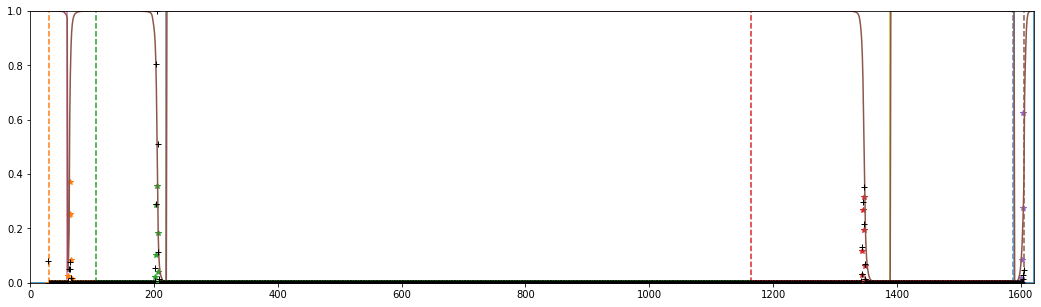

In [39]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in loaded_vidid_selected_frames[cur_vidid + ".txt"]:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
    segment = segment.cpu().numpy()
    print(f"Min prob {i} = {np.min(segment).item()}")
    xs = np.arange(loaded_vidid_selected_frames[cur_vidid + ".txt"][i], 
                   loaded_vidid_selected_frames[cur_vidid + ".txt"][i+1])
    plt.plot(xs, segment, '*')

    
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 
plt.plot(np.arange(item[1][idx].item()), plt_arr)


loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))
loss_arr = -loss_arr[0].detach().cpu().numpy()
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr/np.max(loss_arr), 'k+')

plt.ylim([0, ymax])
plt.xlim([0, item[1][idx].item()])

In [40]:
loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
print(loss_prob.shape)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))

torch.Size([1, 1895, 48])


In [43]:
loss_arr[0].shape

torch.Size([1387])

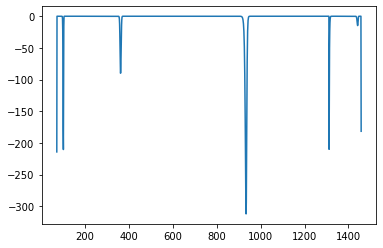

In [45]:
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr[0].detach().cpu().numpy())

In [44]:
es_loss

tensor(3.3987, device='cuda:0', dtype=torch.float64)

In [35]:
video_id_boundary_frames[cur_vidid], loaded_vidid_selected_frames[cur_vidid + ".txt"], item_1[idx]

([75, 345, 1305, 1415, 1440, 1519],
 [73, 282, 455, 1312, 1434, 1458],
 tensor(1520, device='cuda:0', dtype=torch.int32))

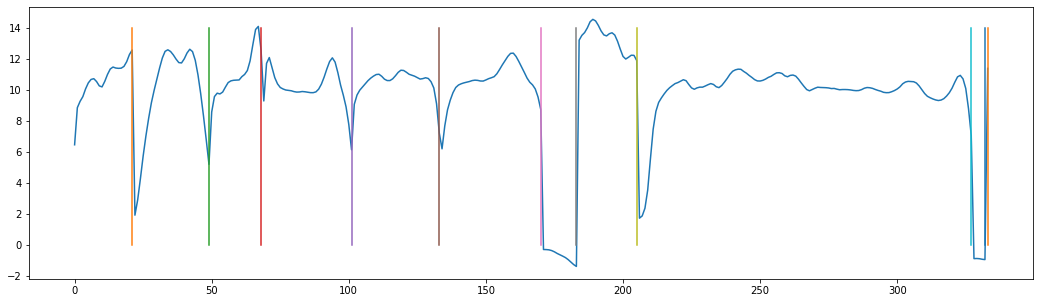

In [41]:
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 14])

torch.Size([334, 334])

In [37]:
cur_features_shortened = cur_vid_feat[:item[1][idx]]
cur_features_shortened[:, item[2][idx][:item[1][idx]]].shape
for

torch.Size([334, 334])

In [26]:
item[2][idx][video_id_boundary_frames[cur_vidid][1]-6:video_id_boundary_frames[cur_vidid][1]+9]

tensor([47, 47, 47, 47, 47, 47, 47,  4,  4,  4,  4,  4,  4,  4,  4])

In [25]:
video_id_boundary_frames[cur_vidid][0]-6,video_id_boundary_frames[cur_vidid][0]+9

6

In [27]:
cur_vid_feat[video_id_boundary_frames[cur_vidid][1]-7:video_id_boundary_frames[cur_vidid][1]+9][:,[47,4]]

tensor([[ 1.0794, 13.3350],
        [ 1.0831, 13.5102],
        [ 1.1767, 13.7662],
        [ 1.3750, 14.0177],
        [ 1.7298, 14.1727],
        [ 2.1706, 14.0367],
        [ 2.7338, 13.4563],
        [ 4.5600, 12.1745],
        [ 7.8450, 10.3246],
        [11.0151,  8.3563],
        [13.4775,  6.6546],
        [14.1836,  5.2898],
        [11.2142,  4.2791],
        [ 5.9829,  3.5694],
        [ 2.3440,  2.9389],
        [ 0.7406,  2.3515]], device='cuda:0')

In [19]:
def add_frames_and_get_classification_value(model_output, count_list, video_ids_list, labels_all, p_criterion):
    new_selected_frames = {}
#     new_selected_frames_probs_values = {}
#     new_selected_frames_labels = {}
    
    labels_arr = []
    probs_arr = []
    
    for i, video_id in enumerate(video_ids_list):
        current_boundary_frames = boundaries_dict[video_id]
        current_video_logits = model_output[i].T
        current_video_count = count_list[i]
        current_selected_frames = loaded_vidid_selected_frames[video_id]
        labels = labels_all[i]
        cur_seg_start = 0
        for seg_num, ele in enumerate(current_boundary_frames):
            cur_seg_end = ele + 1
            total_seg_len = cur_seg_end - cur_seg_start
            per_frames_far_from_boundary = int(0.3 * total_seg_len)
            new_frames_start = cur_seg_start + per_frames_far_from_boundary
            new_frames_end = cur_seg_end - per_frames_far_from_boundary
            
            frames_added = list(range(new_frames_start, new_frames_end))
            frames_added.append(current_selected_frames[seg_num])
            frames_added = list(set(frames_added))
            frames_added.sort()
            new_selected_frames[video_id] = frames_added

            
            labels_seg = torch.stack([labels[current_selected_frames[seg_num]]] * len(frames_added))
            frames_added = torch.tensor(np.array(frames_added), dtype=torch.long, device=current_video_logits.device)
            prob_seg = current_video_logits[frames_added, :]
            
            labels_arr.append(labels_seg)
            probs_arr.append(prob_seg)
            
            cur_seg_start = cur_seg_end
            
    labels_arr = torch.cat(labels_arr)
    probs_arr = torch.cat(probs_arr)
    loss = p_criterion(probs_arr, labels_arr)
    return loss